# import

In [ ]:
import sqlite3
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import pickle
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime, date
from numpy.core._exceptions import UFuncTypeError
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from scipy import sparse
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

from scipy.spatial import distance_matrix,distance
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18,8)

In [ ]:
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')


Running on CoLab


# File name constants

In [ ]:
drive_project_dir = '/content/drive/MyDrive/APLDS/'

df_train_pickle_fn = 'df_train_raw.pickle'
df_train_pickle_path_raw = drive_project_dir + df_train_pickle_fn

df_test_pickle_fn = 'df_test_raw.pickle'
df_test_pickle_path = drive_project_dir + df_test_pickle_fn

df_train_processed_pickle_fn = 'df_train_processed.pickle'
df_train_processed_pickle_path = drive_project_dir + df_train_processed_pickle_fn

y_train_pickle_fn = 'y_train.pickle'
y_train_pickle_path = drive_project_dir + y_train_pickle_fn

ohe_pickle_fn = 'FittedOneHotEncoder.pickle'
ohe_pickle_pathe = drive_project_dir + ohe_pickle_fn

trained_benchmark_xgboost_model_fn = 'trained_bench_xgb'
trained_benchmark_xgboost_model_path = drive_project_dir + trained_benchmark_xgboost_model_fn

# Get the Data

In [ ]:
# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive/')
else:  # Set local path 
    data_path = "C:/Users/User/Desktop/university/year_C_semester_A/stat_lab/"  

Mounted at /content/drive/


In [ ]:
# loading the fires data directly with pickle
with open(df_train_pickle_path_raw, 'rb') as f: #todo
     df_train = pickle.load(f)
with open(df_test_pickle_path, 'rb') as f:
     df_test = pickle.load(f)


# Globals

OneHotEncoder

In [ ]:
ohe = OneHotEncoder(categories='auto', handle_unknown='ignore',sparse = True)

In [ ]:
good_has_features = ['FIRE_NAME','FIRE_CODE']

categorial_features = ['SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 
                       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 
                       'SOURCE_REPORTING_UNIT_NAME', 'OWNER_DESCR', 'STATE',"FIPS_NAME"] 

feature_to_reduce_cardinality = ['NWCG_REPORTING_UNIT_NAME','SOURCE_SYSTEM', "FIPS_NAME", 'SOURCE_REPORTING_UNIT'] 

one_hot_features = feature_to_reduce_cardinality + ['OWNER_DESCR', 'STATE', 'NWCG_REPORTING_AGENCY']

features_to_delete = ["FOD_ID", "FPA_ID", "OBJECTID", "LOCAL_FIRE_REPORT_ID", 
                           "LOCAL_INCIDENT_ID", "ICS_209_INCIDENT_NUMBER", "ICS_209_NAME", "MTBS_ID", 'NWCG_REPORTING_UNIT_ID', 
                           'FIRE_SIZE_CLASS', "OWNER_CODE", 'COMPLEX_NAME', 'FIPS_CODE', 
                           'COUNTY', 'Shape', 'SOURCE_SYSTEM_TYPE', 'CONT_DOY', 'DISCOVERY_DOY', "MTBS_FIRE_NAME",'SOURCE_REPORTING_UNIT_NAME', 
                           'DISCOVERY_DATE', 'CONT_DATE','DISCOVERY_TIME', 'CONT_TIME','STAT_CAUSE_CODE']



In [ ]:
save_load_train_df = False

# Functions

In [ ]:
def clean_data(df,features_to_delete):
  return df.drop(columns=features_to_delete, errors='ignore')

A function to Redoce cardinality of given column

return the columns with the categories that captured {threshold}% of the data, and puts 'other' in the rest.

In [ ]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True,other_name='Other'):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append(other_name)

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else other_name)

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

## convert to date_time

In [ ]:
def fix_julian_date(df, col):
    """
    converts dates from Julian format (float) to datetime
    col - name of the column to convert
    """
    epoch = pd.to_datetime(0, unit='s').to_julian_date()
    disc_dates = df[col]
    df[col] = pd.to_datetime(disc_dates - epoch, unit='D')

In [ ]:
def adding_dates_data(df, features_to_delete):
  try:
    fix_julian_date(df, 'DISCOVERY_DATE')
    fix_julian_date(df, 'CONT_DATE')
  except UFuncTypeError as e:
    print('dates allready converted')

  df['DISCOVERY_WOY'] = df['DISCOVERY_DATE'].dt.week
  df['CONT_WOY'] = df['CONT_DATE'].dt.week
  df['DISCOVERY_MONTH'] = df['DISCOVERY_DATE'].dt.month
  df['CONT_MONTH'] = df['CONT_DATE'].dt.month
  try:
    df['CONT_TIME'] = df['CONT_TIME'].apply(lambda x: pd.to_datetime(x, format='%H%M').time() if x else None)
    df['DISCOVERY_TIME'] = df['DISCOVERY_TIME'].apply(lambda x: pd.to_datetime(x, format='%H%M').time() if x else None)
  except ValueError as e:
    print('conversion of CONT_TIME and/or DISCOVERY_TIME - failed')

  
  return df

# Feature Engineering - Functions

## Engineering Functions

In [ ]:
def features_to_one_hot(df, one_hot_features, ohe, is_test):
  """
  Switches the feature representation to one hot and deletes the original
  """
  if not is_test:
    ohe_arr = ohe.fit_transform(df[one_hot_features])
  else:
    ohe_arr = ohe.transform(df[one_hot_features])
  # Getting all features names
  feature_labels = ohe.categories_
  labels = []
  for i, category in enumerate(feature_labels):
    for sub in category.ravel():
      if sub:
        labels.append(one_hot_features[i] + "_" + sub)

  df_no_onehot = df.drop(columns=one_hot_features)
  all_cols = list(df_no_onehot.columns)
  all_cols.extend(labels)


  df_as_arr = np.array(df_no_onehot,dtype=float)
  sparse_df = sparse.csr_matrix(df_as_arr)
  final_df = sparse.hstack([sparse_df,ohe_arr])
  return final_df, all_cols


In [ ]:
def partial_one_hot(df, column_name, encode_values, drop=False):
  column_names = []
  
  for value in encode_values:
    column_names.append(f"{column_name}_{value}")
    df[column_names[-1]] = np.where(df[column_name]==value,1,0)
  
  if drop:
    df.drop(columns={column_name}, inplace=True)
  
  return column_names

### Adding features
feature engeneering - add features to the data frame

In [ ]:
def calc_duration(row):
  for value in ['CONT_DATE', 'CONT_TIME', 'DISCOVERY_TIME', 'DISCOVERY_DATE']:
    if row[value] is None:
      return

  return datetime.combine(row['CONT_DATE'], row['CONT_TIME']) - datetime.combine(row['DISCOVERY_DATE'], row['DISCOVERY_TIME'])

In [ ]:
def is_holiday(df, date_column):
  cal = calendar()
  holidays = cal.holidays(start=df[date_column].min(), end=df[date_column].max())
  df[f'isHoliday_{date_column}'] = df[date_column].isin(holidays)

In [ ]:
def cyclical_transform_datetime_feature(df, datetime_feature):
    seconds_in_day = 24*60*60
    seconds_in_week = 7 * seconds_in_day

    df[datetime_feature + '_time_in_seconds'] = pd.to_datetime(df[datetime_feature]).values.astype(np.int64) // 10**6

    df[datetime_feature + '_day_sin_time'] = np.sin(2*np.pi*df[datetime_feature + '_time_in_seconds']/seconds_in_day)
    df[datetime_feature + '_day_cos_time'] = np.cos(2*np.pi*df[datetime_feature + '_time_in_seconds']/seconds_in_day)
    df[datetime_feature + '_sin_time_week'] = np.sin(2*np.pi*df[datetime_feature + '_time_in_seconds']/seconds_in_week)
    df[datetime_feature + '_cos_time_week'] = np.cos(2*np.pi*df[datetime_feature + '_time_in_seconds']/seconds_in_week)

In [ ]:
def cyclical_transform_time_feature(df, hour_feature_name, features_to_delete):
  df.hour_feature_name = df_train[hour_feature_name].apply(lambda x: x.hour + x.minute/60 if not x is None else None)

  df[f'{hour_feature_name}_hr_sin'] = np.sin(df.hour_feature_name*(2.*np.pi/24))
  df[f'{hour_feature_name}_hr_cos'] = np.cos(df.hour_feature_name*(2.*np.pi/24))

  features_to_delete.append(hour_feature_name)

In [ ]:
def increased_poweline(row):
  if row['FIRE_YEAR'] > 2009 or (row['FIRE_YEAR'] == 2009 and row['DISCOVERY_WOY'] >=4):
    return 1  
  return 0

def missing_values_decrease(row):
  if row['FIRE_YEAR'] > 1996 and row['FIRE_YEAR'] < 2003 or (row['FIRE_YEAR'] == 1996 and row['DISCOVERY_WOY'] >= 41):
    return 1

  if row['FIRE_YEAR'] > 2012 and row['FIRE_YEAR'] < 2015:
    return 1
  
  if (row['FIRE_YEAR'] == 2012 and row['DISCOVERY_WOY'] <= 9) and (row['FIRE_YEAR'] == 2015 and row['DISCOVERY_WOY'] <= 33):
    return 1

  return 0

def decrease_rail(row):
  if row['FIRE_YEAR'] >= 1992 and row['FIRE_YEAR'] < 2002:
    return 1
  if row['FIRE_YEAR'] == 2002 and row['DISCOVERY_WOY'] < 41:
    return 1
  return 0

In [ ]:
def add_features(df, good_has_features, features_to_delete):
  """
  Adds features to the dataframe
  """
  # Time
  df['WEEKDAY'] =  df['DISCOVERY_DATE'].dt.weekday  # add day of week column

  cyclical_transform_datetime_feature(df, 'DISCOVERY_DATE')
  cyclical_transform_datetime_feature(df, 'CONT_DATE')
  #cyclical_transform_time_feature(df, 'CONT_TIME', features_to_delete)
  #cyclical_transform_time_feature(df, 'DISCOVERY_TIME', features_to_delete)

  df['Area_of_independent'] = ((df['DISCOVERY_WOY'] > 23) & (df['DISCOVERY_WOY'] < 27)).astype(int)
  df['increased_poweline_cases'] = df.apply(increased_poweline, axis=1)
  df['decreased_missing_values'] = df.apply(missing_values_decrease, axis=1)
  df['decreased_railroad'] = df.apply(decrease_rail, axis=1)
  df['increased_lighting_cases'] = df['DISCOVERY_WOY'].apply(lambda x:1 if x >= 19 and x<= 41 else 0)


  df['DURATION'] = df.apply(calc_duration,axis=1).astype('timedelta64[s]')

  # scale the DURATION
  df['DURATION'] = (df['DURATION']-df['DURATION'].min())/(df['DURATION'].max()-df['DURATION'].min())

  # Adding holidays
  is_holiday(df, "DISCOVERY_DATE")
  is_holiday(df, "CONT_DATE")

  # "has" features
  for feature in good_has_features:
    df = add_has_feature(df, feature)
  # # remove original features
  df = df.drop(good_has_features, axis=1, errors='ignore')


  return df

A function to add has_feature feature

In [ ]:
def add_has_feature(df, feature):
  """
  Adds has_feature to the df while removing the feature itself
  """
  df[f"HAS_{feature}"] = df[feature].isna()
  return df

In [ ]:
def reducing_cardinality(df,feature_to_reduce_cardinality,thershold):
  categories_list_dict = {}
  for feature in feature_to_reduce_cardinality:
    new_col, categories_list = cumulatively_categorise(df[feature], thershold, other_name=f'Other_{feature}')
    df[feature] = new_col
    categories_list_dict[feature] = categories_list

  return df, categories_list_dict

In [ ]:
def reduce_cardinality_test(df,feature_to_reduce_cardinality,categories_list_dict):
  for feature in feature_to_reduce_cardinality:
    lst = categories_list_dict[feature]
    df[feature] = df[feature].apply(lambda x : x if x in lst else f'Other_{feature}')
  return df

# Final dataframe before fiting model

In [ ]:
def preprocess(df, features_to_delete, good_has_features, one_hot_features,feature_to_reduce_cardinality,ohe,is_test, categories_list_dict=None):
  """
  Returns the df after preprocessing.
  """
  if is_test and 'STAT_CAUSE_DESCR' in df.columns:
    Y = df['STAT_CAUSE_DESCR']
    df.drop(columns=['STAT_CAUSE_DESCR'] ,inplace=True, errors='ignore')
  print("Starting date processing")

  df = adding_dates_data(df, features_to_delete)

  print("Finished date processing")


  print("Starting adding features")
  df = add_features(df, good_has_features, features_to_delete)
  print("Finished adding feature")

  # TODO: standared scaler!!!!

  print("Starting cleaning data")
  df = clean_data(df, features_to_delete)
  print("Finished cleaning data")
  
  #Adding one hot representation for not all values
  print("Starting reducing cardinality")
  if not is_test:
    df, categories_list_dict = reducing_cardinality(df,feature_to_reduce_cardinality,thershold=0.8)
  else:
    df = reduce_cardinality_test(df,feature_to_reduce_cardinality,categories_list_dict)
  print("Finished reducing cardinality")
  if not is_test:
    Y = df['STAT_CAUSE_DESCR']
    df.drop(columns=['STAT_CAUSE_DESCR'], inplace=True, errors='ignore')
  # Adding one hot
  print("Starting adding one hot")
  df_as_sparse , feature_labels = features_to_one_hot(df, one_hot_features, ohe, is_test) 
  print("Finished adding one hot")
  if is_test:
    return df_as_sparse,Y
  return df_as_sparse, Y, feature_labels, categories_list_dict

# Run Preprocess

In [ ]:
df_train_after_preprocess_sparse_sample, Y_labels_sample, feature_labels, categories_list_dict = preprocess(df_train.sample(50000), features_to_delete, good_has_features, one_hot_features,feature_to_reduce_cardinality,ohe,is_test=False)

Starting date processing
Finished date processing
Starting adding features
Finished adding feature
Starting cleaning data
Finished cleaning data
Starting reducing cardinality
Finished reducing cardinality
Starting adding one hot
Finished adding one hot


In [ ]:
df_train_after_preprocess_sparse, Y_labels, feature_labels, categories_list_dict = preprocess(df_train, features_to_delete, good_has_features, one_hot_features,feature_to_reduce_cardinality,ohe,is_test=False)


Starting date processing
Finished date processing
Starting adding features
Finished adding feature
Starting cleaning data
Finished cleaning data
Starting reducing cardinality
Finished reducing cardinality
Starting adding one hot
Finished adding one hot


In [ ]:
Y_labels.to_pickle(y_train_pickle_path)
pickle.dump(ohe, open(ohe_pickle_pathe, "wb"))
pickle.dump(df_train_after_preprocess_sparse, open(df_train_processed_pickle_path, "wb"))
# export the train and the encoder.

# get the Data again

In [ ]:
with open(df_train_processed_pickle_path, 'rb') as f:
     X_train = pickle.load(f)
with open(ohe_pickle_pathe, 'rb') as f:
     ohe = pickle.load(f)
with open(y_train_pickle_path, 'rb') as f:
     Y_train = pickle.load(f)

In [ ]:
def train_model(X_train, y_train, model_type, parameters=dict()):

  if model_type == 'xgb':
    model = XGBClassifier(**parameters)
  elif model_type == 'clf':
    model = RandomForestClassifier(**parameters)
  else:
    return

  print("begin train")
  model.fit(X_train, y_train)
  print("finish train")

  if model_type == 'xgb':
    print("saving xgb trained model")
    model.save_model(trained_benchmark_xgboost_model_path)

  return model

Get a sample

In [ ]:
sample_df = df_train.sample(200000)

In [ ]:
sample_df, sample_df_y, feature_labels, categories_list_dict = preprocess(sample_df, features_to_delete, good_has_features, one_hot_features,feature_to_reduce_cardinality,ohe=ohe,is_test=False)

Starting date processing
Finished date processing
Starting adding features
Finished adding feature
Starting cleaning data
Finished cleaning data
Starting reducing cardinality
Finished reducing cardinality
Starting adding one hot
Finished adding one hot


##Train model

In [ ]:
xgb = train_model(sample_df, sample_df_y, 'xgb')

begin train
finish train
saving xgb trained model


## Evaluate model

In [ ]:
def get_train_test_score(model, x_train, x_test, y_train, y_test, train=False):
  """
  Prints the score for the train and the test sets for the given model
  """
  if train:
    model.fit(x_train, y_train)
  # test
  y_hat = model.predict_proba(x_train)
  train_score = roc_auc_score(y_train, y_hat,  average='macro', multi_class='ovr')
  # train
  y_hat_test = model.predict_proba(x_test)
  test_score = roc_auc_score(y_test, y_hat_test,  average='macro', multi_class='ovr')

  print(f"Train score:{train_score}, test score:{test_score}")

In [ ]:
df_test_x, df_test_y = preprocess(df_test,features_to_delete, good_has_features, one_hot_features,feature_to_reduce_cardinality,ohe,True,categories_list_dict)

Starting date processing
Finished date processing
Starting adding features
Finished adding feature
Starting cleaning data
Finished cleaning data
Starting reducing cardinality
Finished reducing cardinality
Starting adding one hot
Finished adding one hot


In [ ]:
get_train_test_score(xgb, sample_df, df_test_x, sample_df_y, df_test_y)

Train score:0.8621286684722406, test score:0.8549412679749284


#Benchmark model

A very basic benchmark model - choosing a very simple subset of the original features, not doing any fancy feature engeneering or HPO, just taining a Random Forest classifier with defult parameters on a sample of 200,000 data points

In [ ]:
rf_benchmark_cols = ['FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_CODE','FIRE_SIZE', 'LATITUDE', 'LONGITUDE']
with open(df_train_pickle_path_raw, 'rb') as f:
     df_train = pickle.load(f).sample(200000)[rf_benchmark_cols]
with open(df_test_pickle_path, 'rb') as f:
     df_test = pickle.load(f)[rf_benchmark_cols]

Train

In [ ]:
y_train = df_train['STAT_CAUSE_CODE']
x_train = df_train.drop(columns=['STAT_CAUSE_CODE'])

rf_becnmark_model = train_model(x_train, y_train, 'clf')

begin train
finish train


Get train and test ROC AUC socres.

In [ ]:
y_test = df_test['STAT_CAUSE_CODE']
x_test = df_test.drop(columns=['STAT_CAUSE_CODE'])

print("Random forest benchmark model evaluation:")
get_train_test_score(rf_becnmark_model, x_train, x_test, y_train, y_test)

Random forest benchmark model evaluation:
Train score:0.9999999654888018, test score:0.8229253043852318


#Feature Importance

In [ ]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.get_booster().get_fscore()
    a = np.zeros(len(feat_names))
    for i in range(a.shape[0]):
      a[i] = float(imp_vals.get('f'+str(i),0.))
    
    return a

In [ ]:
imp = get_xgb_imp(xgb, feature_labels)
imp_sorted = np.sort(imp)
order = np.argsort(imp)
labels_sorted = np.array(feature_labels)[order]

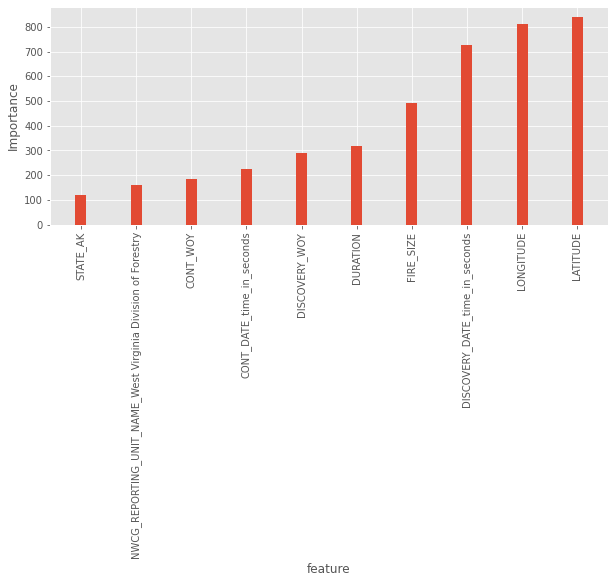

In [ ]:
#Change top to the number of features you want to present
top = 10
fig, ax = plt.subplots(figsize = (10,4))

idx = np.asarray([i for i in range(top)])

width = 0.2

ax.bar(idx, imp_sorted[-top:], width=width)

ax.set_xticks(idx)
ax.set_xticklabels(labels_sorted[-top:], rotation=90)
ax.set_xlabel('feature')
ax.set_ylabel('Importance')


plt.show()

## Experiment features importance 

In this experiment we wanted to check whether or not removing not important features will imporove the model's preformance. We run this experiment a few times and the results are explained in the report. 
First, we trained our base model on all of the features, than we calculated feature importance for each of our features and evaluated the model.
We choose not important to be features with 0 importance, we removed them from the training data and the test data and evaluated the model. Then we compared the model's performance before and after removing the not importatnt features.

In [ ]:

not_important_tresh = 0
important_features = order[np.where(imp_sorted > not_important_tresh)[0][0]:]


In [ ]:
new_sample_df = sample_df.tocsr()[:,important_features]
xgb = train_model(new_sample_df, sample_df_y, 'xgb')
get_train_test_score(xgb, new_sample_df, df_test_x.tocsr()[:,important_features], sample_df_y, df_test_y)

XGBClassifier(objective='multi:softprob')

# Choosing Hyperparameters

In [ ]:
def objective(space):
    clf= XGBClassifier(
                    n_estimators =int(space['n_estimators']), eta = space['eta'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(sample_df, sample_df_y), ( df_test_x, df_test_y)]
    
    clf.fit(sample_df, sample_df_y, verbose=False)
    
    y_hat_test = clf.predict_proba(df_test_x)

    roc_auc = roc_auc_score(df_test_y, y_hat_test, average='macro', multi_class='ovr')
    print (f"ROC AUC score:{roc_auc}")

    # We want to maximize the roc auc therefore minimize the minuse of it.
    return {'loss': -roc_auc, 'status': STATUS_OK }

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 15, 1),
        'eta' :  hp.uniform('eta', 0, 1),
        'gamma': hp.uniform ('gamma', 0, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators':  hp.quniform("n_estimators", 50, 200, 1),
        'seed': 0
    }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

ROC AUC score:0.6677955837900961
ROC AUC score:0.6689487308618873
ROC AUC score:0.6876925359186269
ROC AUC score:0.614991250373077
ROC AUC score:0.6913657325772079
ROC AUC score:0.6785015867644558
ROC AUC score:0.6883688280196859
ROC AUC score:0.6927603691705766
ROC AUC score:0.6843615060879663
ROC AUC score:0.6890142603332622
ROC AUC score:0.6933006617258111
ROC AUC score:0.6545235254457802
ROC AUC score:0.6917849371949036
ROC AUC score:0.7120971770231582
ROC AUC score:0.6329484964537245
ROC AUC score:0.6738042152468691
ROC AUC score:0.6875933648635731
ROC AUC score:0.6215289952917102
ROC AUC score:0.6938486269947367
ROC AUC score:0.6782664239321524
ROC AUC score:0.7164859100662345
ROC AUC score:0.716929977066675
ROC AUC score:0.7115419423981888
ROC AUC score:0.7108297348866249
ROC AUC score:0.707335962086493
ROC AUC score:0.7097733318069364
ROC AUC score:0.7049741640994964
ROC AUC score:0.6838736376659205
ROC AUC score:0.6819277554442109
ROC AUC score:0.7072547089700388
ROC AUC score

In [ ]:
print(f"Best parameters are:\n{best_hyperparams}")

Best parameters are:
{'colsample_bytree': 0.9911191130678206, 'eta': 0.49685865594047707, 'gamma': 1.4308614729557847, 'max_depth': 6.0, 'min_child_weight': 4.0, 'n_estimators': 196.0, 'reg_alpha': 40.0, 'reg_lambda': 0.91095884549275}


In [ ]:
for item in ['max_depth', 'min_child_weight','n_estimators','reg_alpha']:
  best_hyperparams[item] = int(best_hyperparams[item])

In [ ]:
best_para_mod = train_model(sample_df, sample_df_y, 'xgb', best_hyperparams)

begin train
finish train
saving xgb trained model


In [ ]:
get_train_test_score(best_para_mod, sample_df, df_test_x, sample_df_y, df_test_y)